In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

# отключим вывод варнингов
import warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('stud_math.csv')

In [46]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [48]:
df.isnull().sum()  # Проверим пустые значения

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Необходимо проанализировать каждый показатель и сделать что-то с пустыми значениями.У первых трех показателей нет пропусков. Достаточно посмотреть какое распределение ответов

In [6]:
df.school.value_counts()

GP    349
MS     46
Name: school, dtype: int64

In [7]:
df.sex.value_counts()

F    208
M    187
Name: sex, dtype: int64

In [41]:
df.age.value_counts()

16    103
17     98
18     82
15     81
19     24
20      3
22      1
21      1
Name: age, dtype: int64

Есть взрослые ребята, причем их всего по одному, можно удалить 21 и 22. Можно было бы их сложить и сделать 20 и страше, но тогда нарушатся отличные показатели 20-летних. 

In [49]:
df = df.drop(df['age'][df.age > 20].index)

In [50]:
df.age.unique()

array([18, 17, 15, 16, 19, 20])

In [51]:
df.address.value_counts()

U    294
R     82
Name: address, dtype: int64

Если мы увеличим число городских жителей на отсутствующие пять процентов ответов, это недолжно сильно исказить данные 


In [52]:
df['address'] = df['address'].fillna('U')

In [53]:
df.address.unique()

array(['U', 'R'], dtype=object)

In [55]:
df.address.isnull().sum()  # все получилось. Идем дальше

0

In [57]:
df.famsize.value_counts(normalize=True)

GT3    0.70765
LE3    0.29235
Name: famsize, dtype: float64

Аналогично заменяю отсутствующие данные чаще встречающимся показателем. Тем более что так же как и у городских жителей, разброс у больших семей большой и включает все результаты score

In [58]:
df['famsize'] = df['famsize'].fillna('GT3')

In [59]:
df.famsize.value_counts(normalize=True)
# провепряем, как изменились данные

GT3    0.727735
LE3    0.272265
Name: famsize, dtype: float64

In [60]:
df.Pstatus.value_counts(normalize=True)  # тоже самое

T    0.896552
A    0.103448
Name: Pstatus, dtype: float64

In [61]:
df['Pstatus'] = df['Pstatus'].fillna('T')

In [62]:
df.Pstatus.value_counts(normalize=True)  # все ок

T    0.908397
A    0.091603
Name: Pstatus, dtype: float64

В образовании матери всего три пустых значения - удалим их. А еще в другом окне у меня есть бокспоты и тест стьдента, сделанный на сырых данных. И я все время на них ориентируюсь, но сюда я их решила не вставлять, потому что вы множество раз написали, что делать с пустыми данными все это нельзя! Так вот оттуда я знаю, что это самый важный показатель. Но и пустым значений в нем очень мало. 

In [63]:
df.Medu.value_counts(normalize=True)

4.0    0.335897
2.0    0.261538
3.0    0.246154
1.0    0.148718
0.0    0.007692
Name: Medu, dtype: float64

In [154]:
df1 = df.copy()

In [155]:
df1 = df1.dropna(subset=['Medu'])

In [156]:
df1.Medu.isna().sum()

0

In [157]:
df1.Fedu.value_counts()

2.0     105
3.0      95
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64

In [158]:
df1.Fedu.isna().sum()

24

In [159]:
df1.Fedu.isna().sum()

24

In [160]:
df1.Fedu.isna().sum()

24

In [161]:
df1.Fedu.isna().sum()

24

In [162]:
df1.Mjob.value_counts()

other       130
services     96
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

Пустые можно прибавить к другим.

In [163]:
df1['Mjob'] = df1['Mjob'].fillna('other')

In [164]:
df1.Mjob.value_counts()

other       149
services     96
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

In [165]:
df1.Fjob.value_counts()

other       195
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

In [166]:
df1['Fjob'] = df1['Fjob'].fillna('other')

In [167]:
df1.Fjob.value_counts()

other       231
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

In [168]:
df1.reason.value_counts()

course        136
home          103
reputation    101
other          33
Name: reason, dtype: int64

In [169]:
df1['reason'] = df1['reason'].fillna('other')

In [170]:
df1.reason.value_counts()

course        136
home          103
reputation    101
other          50
Name: reason, dtype: int64

In [171]:
df1.guardian.value_counts()

mother    248
father     84
other      28
Name: guardian, dtype: int64

In [172]:
df1['guardian'] = df1['guardian'].fillna('other')

In [173]:
df1.guardian.value_counts()

mother    248
father     84
other      58
Name: guardian, dtype: int64

In [174]:
df1.traveltime.value_counts()

1.0    237
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

In [175]:
df1['traveltime'] = df1['traveltime'].fillna(1)

Здесь заменяем на наибольший показатель, потому что разрыв огромный, а 1 покрывает весь  score на боксплоте, поэтому выбросов не предвидется

In [176]:
df1.traveltime.value_counts()

1.0    265
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

In [177]:
df1.studytime.value_counts()

2.0    192
1.0    100
3.0     64
4.0     27
Name: studytime, dtype: int64

In [178]:
df1['studytime'] = df1['studytime'].fillna(2)

In [179]:
df1.studytime.value_counts()

2.0    199
1.0    100
3.0     64
4.0     27
Name: studytime, dtype: int64

In [180]:
df1.failures.value_counts()

0.0    291
1.0     48
2.0     16
3.0     13
Name: failures, dtype: int64

In [181]:
df1['failures'] = df1['failures'].fillna(0)

In [182]:
df1.failures.value_counts()

0.0    313
1.0     48
2.0     16
3.0     13
Name: failures, dtype: int64

In [183]:
df1.schoolsup.value_counts()

no     332
yes     50
Name: schoolsup, dtype: int64

In [184]:
df1['schoolsup'] = df1['schoolsup'].fillna('no')

In [185]:
df1.schoolsup.value_counts()

no     340
yes     50
Name: schoolsup, dtype: int64

In [186]:
df2 = df1.copy()

In [187]:
df2.famsup.value_counts()

yes    217
no     134
Name: famsup, dtype: int64

А вот здесь разница небольшая, и просто добавить кому-то 30 пустых значений - нельзя. Судя по боксплоту, у да разброс значения score шире, чем у нет. То есть дети, которым дома не помогают, меньше получают двойки. Поэтому добавим их в да. 

In [190]:
df2['famsup'] = df2['famsup'].fillna('yes')

In [191]:
df2.famsup.value_counts()

yes    256
no     134
Name: famsup, dtype: int64

In [192]:
df2.paid.value_counts()

no     195
yes    155
Name: paid, dtype: int64

Отнесем пустые значения к неоплачиваемым, потом у что у них широкий разброс результатов score


In [193]:
df2['paid'] = df2['paid'].fillna('no')

In [194]:
df2.paid.value_counts()

no     235
yes    155
Name: paid, dtype: int64

In [196]:
df2.activities.value_counts()

yes    194
no     182
Name: activities, dtype: int64

А здесь попробуем ввести третью переменную - не знаю (idk). Во-первых, потому что размах относительно score у боксплотов не большой, а нули показываются как выбросы. А во-вторых, попробую другой вариат... 

In [198]:
df3 = df2.copy()
df3['activities'] = df3['activities'].fillna('idk')

In [199]:
df3.activities.value_counts()

yes    194
no     182
idk     14
Name: activities, dtype: int64

In [200]:
df3.nursery.value_counts()

yes    297
no      77
Name: nursery, dtype: int64

In [201]:
df3['nursery'] = df3['nursery'].fillna('yes')

In [203]:
df3.nursery.value_counts()

yes    313
no      77
Name: nursery, dtype: int64

In [212]:
df5 = df3.copy()
df5['granular'] = df5['studytime, granular'].rename('granular')

In [213]:
df5.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,score,granular
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,...,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,-6.0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,...,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,-6.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0,-6.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,...,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,-9.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,-6.0


In [214]:
df6 = df5.copy()

In [218]:
df6 = df6.drop(columns=['studytime, granular'])

In [219]:
df6.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,score,granular
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,...,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,-6.0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,...,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,-6.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0,-6.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,...,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,-9.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,-6.0


In [220]:
df6.granular.value_counts()

-6.0     192
-3.0     100
-9.0      64
-12.0     27
Name: granular, dtype: int64

In [222]:
df7 = df6.copy()
df7['granular'] = df7['granular'].fillna(-6)

In [223]:
df7.granular.value_counts()

-6.0     199
-3.0     100
-9.0      64
-12.0     27
Name: granular, dtype: int64

In [224]:
df7.higher.value_counts()

yes    354
no      17
Name: higher, dtype: int64

In [225]:
df7['higher'] = df7['higher'].fillna('yes')

In [227]:
df7.higher.value_counts()

yes    373
no      17
Name: higher, dtype: int64

In [228]:
df7.internet.value_counts()

yes    303
no      54
Name: internet, dtype: int64

In [229]:
df7['internet'] = df7['internet'].fillna('yes')

In [230]:
df7.internet.value_counts()

yes    336
no      54
Name: internet, dtype: int64

In [231]:
df7.romantic.value_counts()

no     237
yes    123
Name: romantic, dtype: int64

In [232]:
df7['romantic'] = df7['romantic'].fillna('no')

In [233]:
df7.famrel.value_counts()

 4.0    181
 5.0     96
 3.0     61
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [234]:
df8 = df7.copy()

In [235]:
df8['famrel' == -1] = 1

In [236]:
df8.famrel.value_counts()

 4.0    181
 5.0     96
 3.0     61
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [238]:
df8.famrel[df8.famrel < 0]

25   -1.0
Name: famrel, dtype: float64

In [239]:
df8.famrel[25] = 1

In [241]:
df8.famrel.value_counts()

4.0    181
5.0     96
3.0     61
2.0     17
1.0      8
Name: famrel, dtype: int64

In [242]:
df8['famrel'] = df8['famrel'].fillna(4)

In [244]:
df8.famrel.value_counts()

4.0    208
5.0     96
3.0     61
2.0     17
1.0      8
Name: famrel, dtype: int64

In [245]:
df8.freetime.value_counts()

3.0    151
4.0    111
2.0     63
5.0     36
1.0     18
Name: freetime, dtype: int64

In [246]:
df8['freetime'] = df8['freetime'].fillna(3)

In [247]:
df8.goout.value_counts()

3.0    126
2.0    100
4.0     83
5.0     51
1.0     23
Name: goout, dtype: int64

In [248]:
df8['goout'] = df8['goout'].fillna(3)

In [250]:
df8.health.value_counts()

5.0    137
3.0     88
4.0     63
1.0     46
2.0     41
Name: health, dtype: int64

In [251]:
df8['health'] = df8['health'].fillna(5)

In [253]:
df8.absences.value_counts()

0.0      110
2.0       60
4.0       52
6.0       31
8.0       20
10.0      17
12.0      12
14.0      12
3.0        7
16.0       6
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

In [254]:
df8['absences'] = df8['absences'].fillna(0)

In [255]:
df8.absences.value_counts()

0.0      122
2.0       60
4.0       52
6.0       31
8.0       20
10.0      17
12.0      12
14.0      12
3.0        7
16.0       6
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

In [256]:
df8.score.value_counts()

50.0     53
55.0     46
0.0      36
75.0     33
65.0     31
60.0     31
40.0     30
70.0     27
45.0     27
80.0     16
30.0     14
90.0     12
35.0      8
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

In [263]:
df10 = df8.copy()

In [264]:
df10 = df10.dropna(subset=['score'])

In [265]:
df10.Fedu.value_counts()

2.0     104
3.0      93
4.0      88
1.0      72
0.0       2
40.0      1
Name: Fedu, dtype: int64

In [266]:
df10.Fedu[11] = 4

In [267]:
df10.Fedu.value_counts()

2.0    104
3.0     93
4.0     89
1.0     72
0.0      2
Name: Fedu, dtype: int64

не знаю я, что делать с этими отцами... попробую пока так... 

In [269]:
df10['Fedu'] = df10['Fedu'].fillna(99)

In [270]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df10.loc[df10.loc[:, column].isin(
                    df10.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

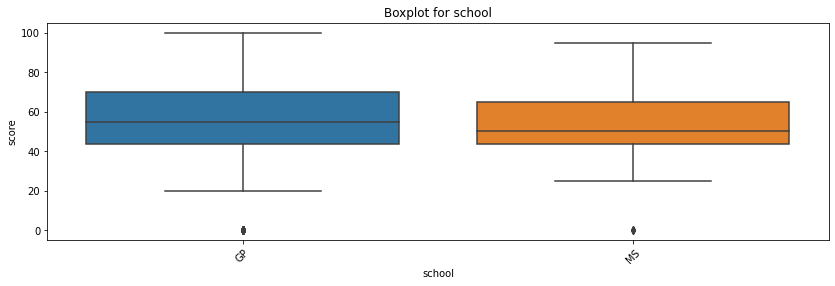

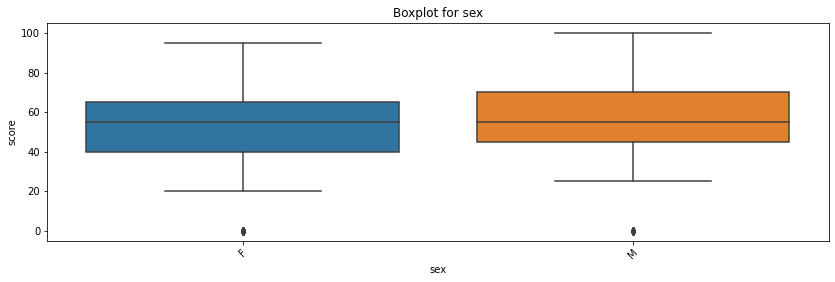

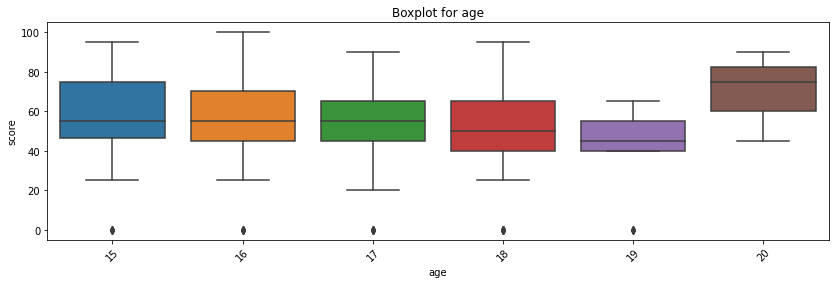

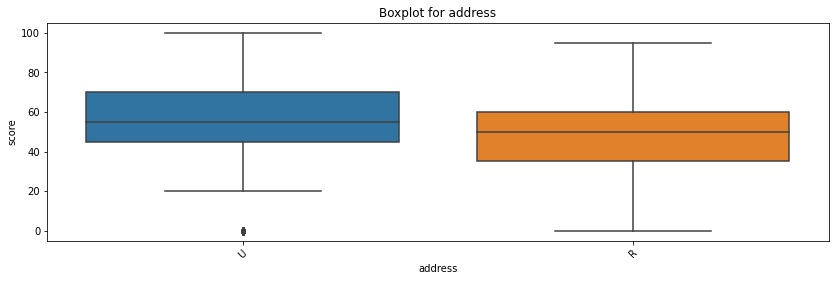

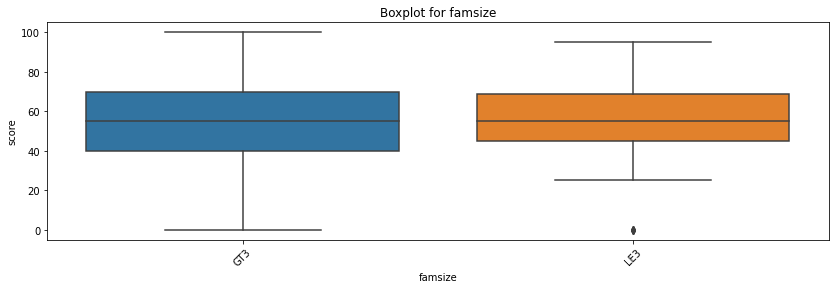

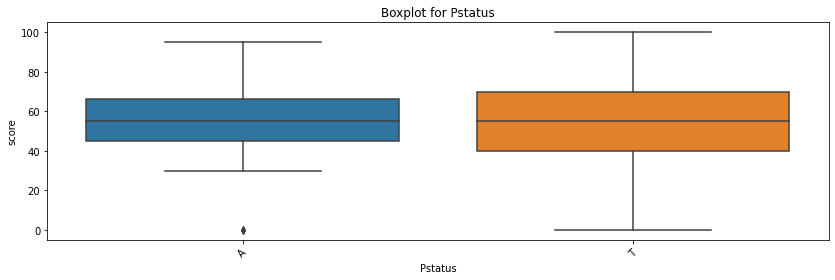

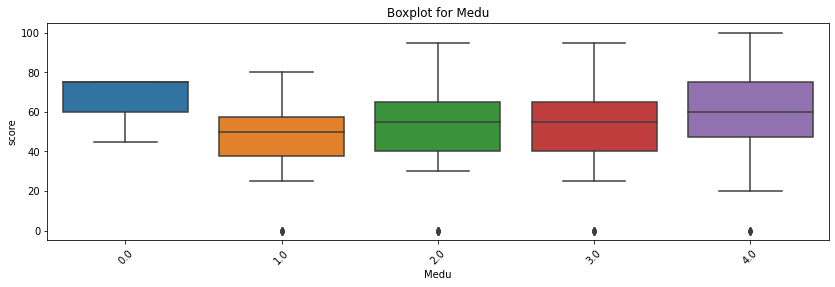

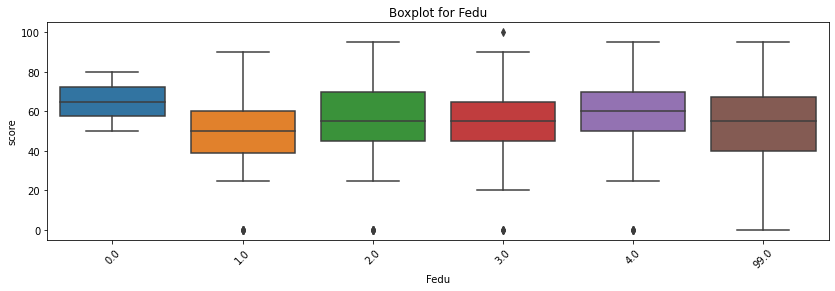

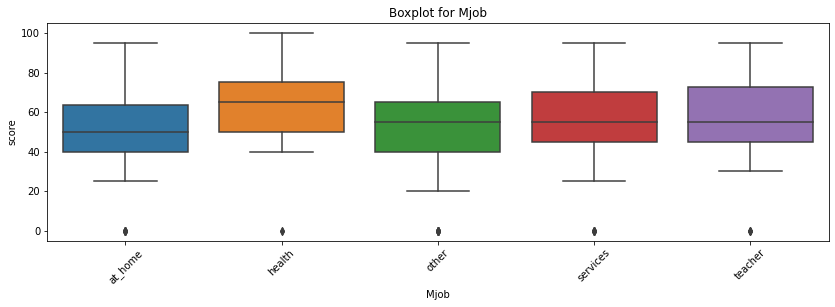

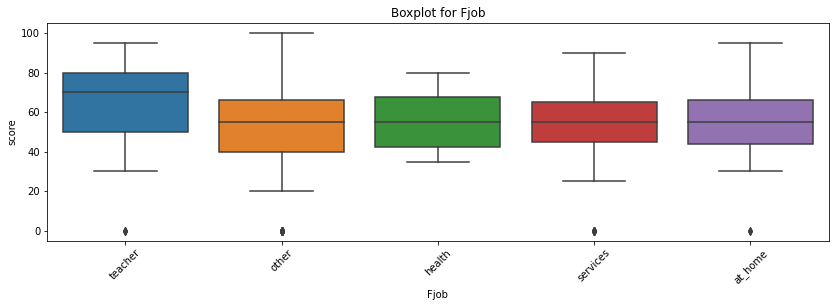

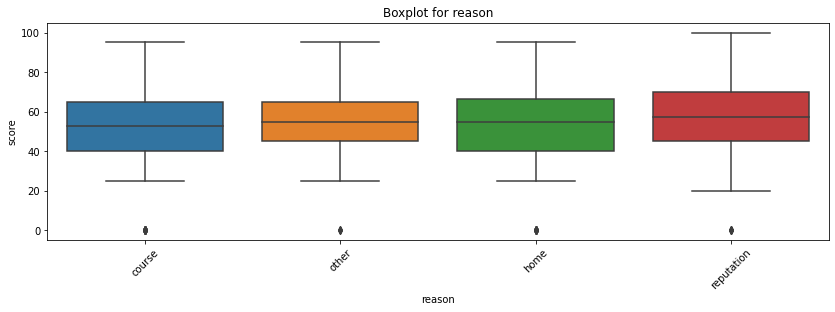

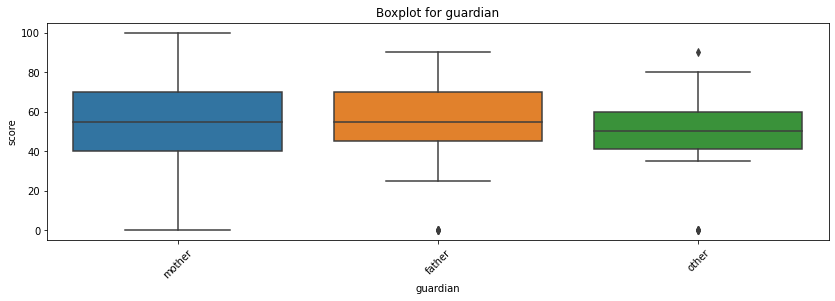

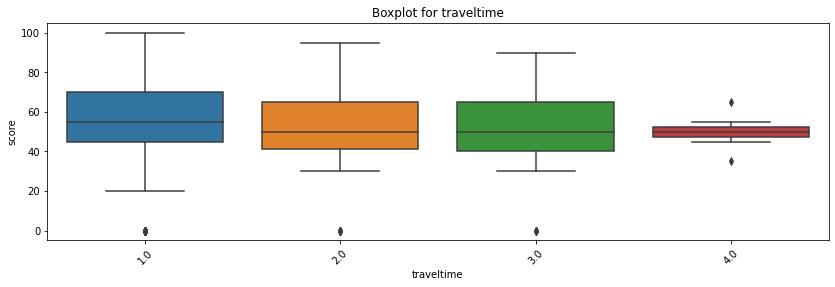

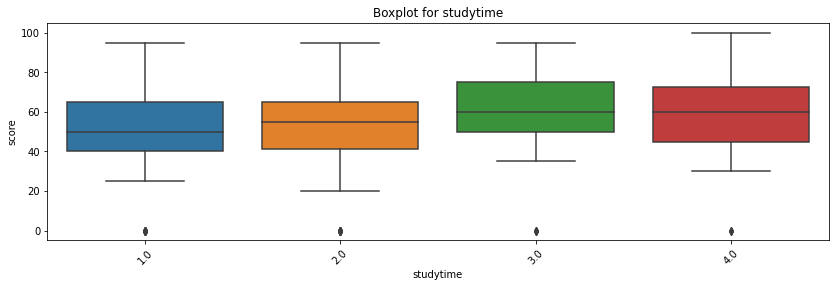

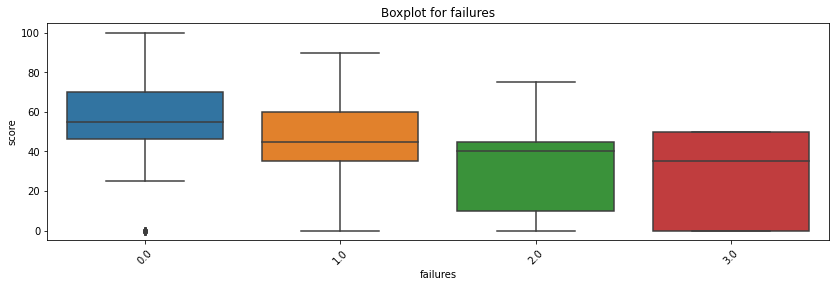

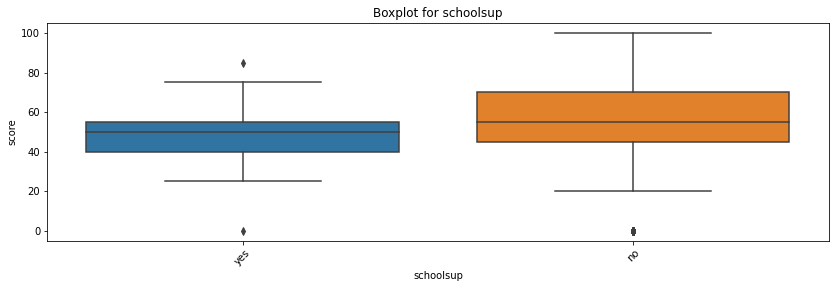

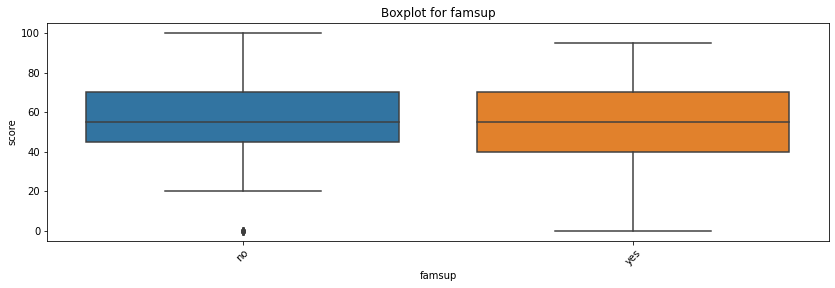

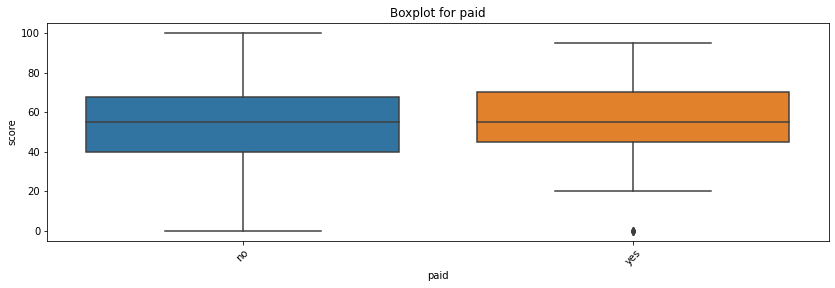

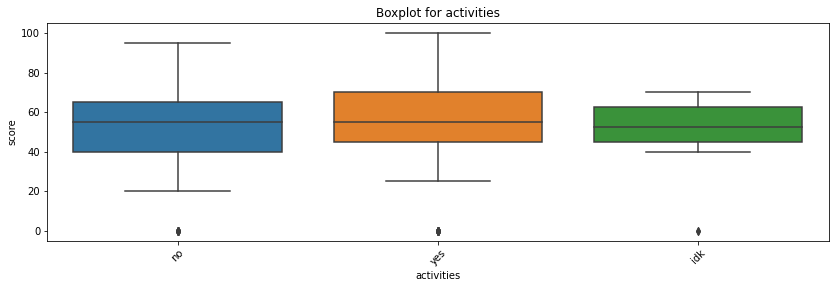

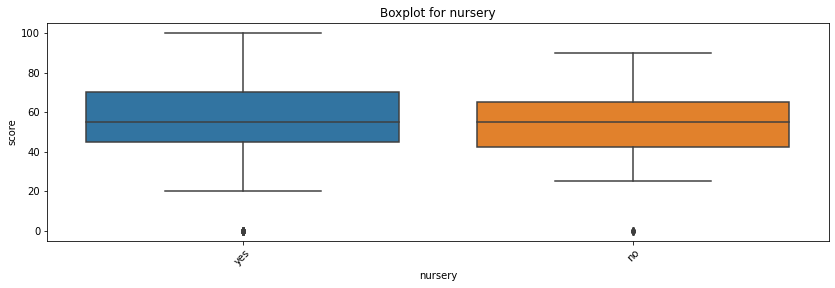

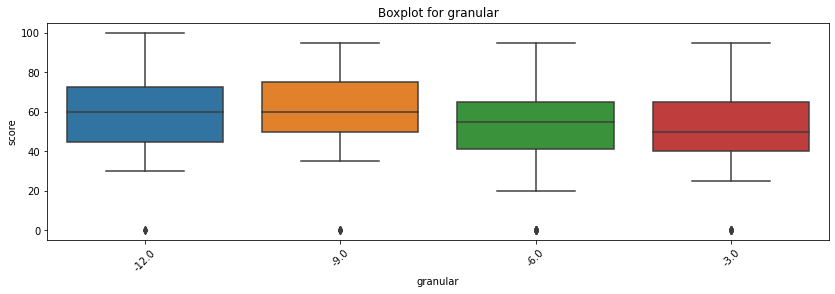

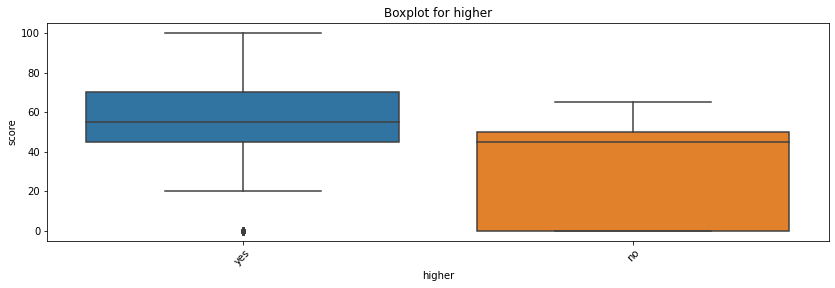

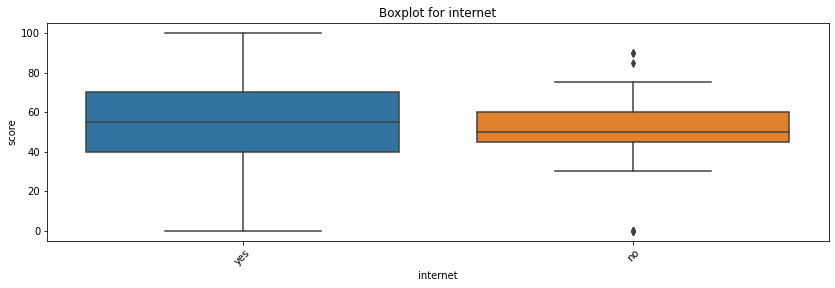

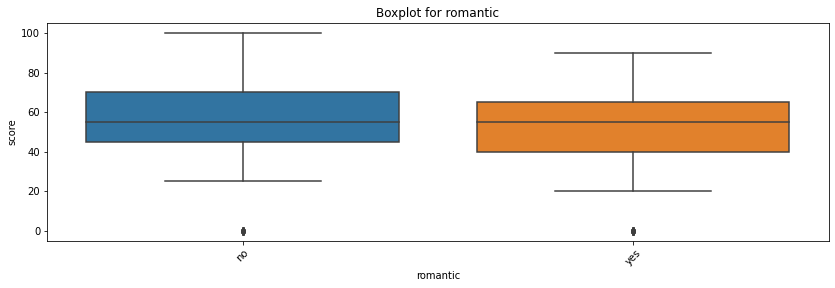

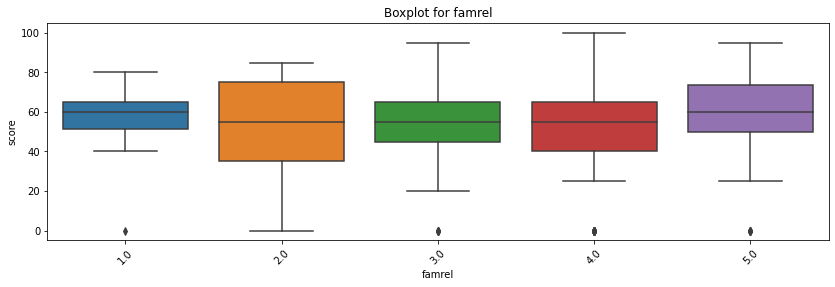

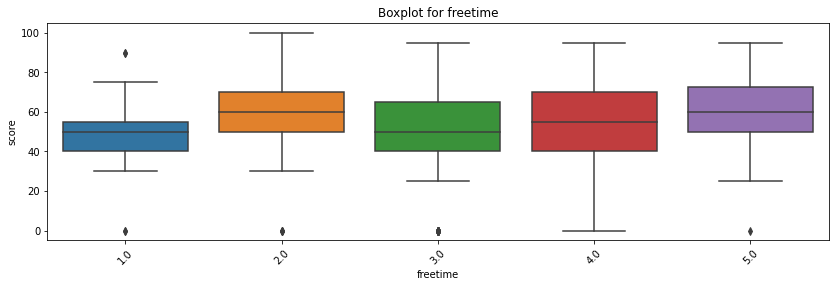

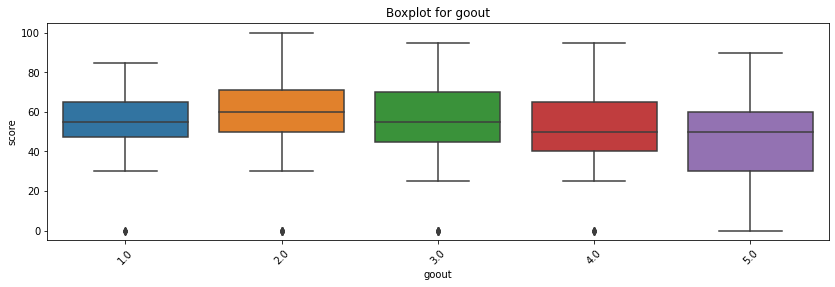

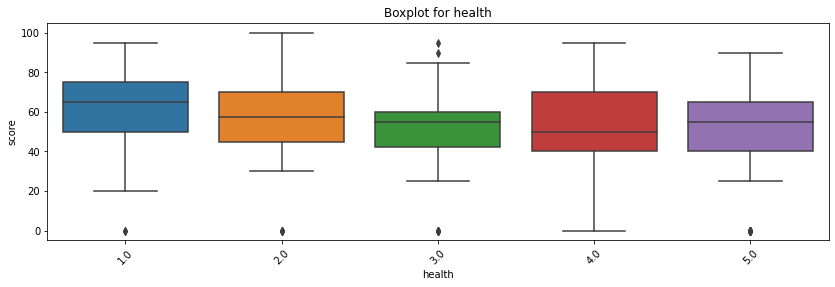

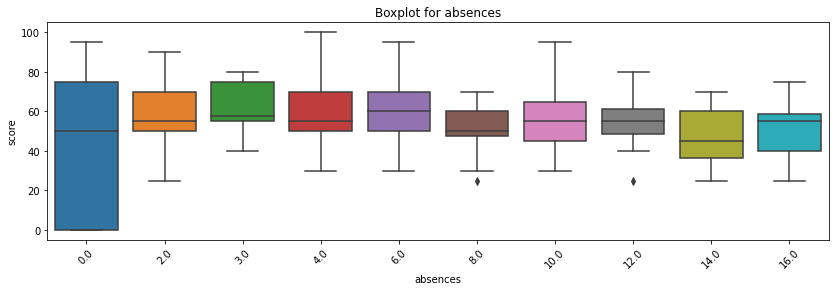

In [271]:
for col in [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob',
    'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
    'famsup', 'paid', 'activities', 'nursery', 'granular', 'higher', 'internet',
    'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences'
]:
    get_boxplot(col)

In [273]:
df10.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
health        0
absences      0
score         0
granular      0
False         0
dtype: int64

In [274]:
def get_stat_dif(column):
    cols = df10.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df10.loc[df10.loc[:, column] == comb[0], 'score'],
                     df10.loc[df10.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [275]:
for col in [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob',
    'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
    'famsup', 'paid', 'activities', 'nursery', 'granular', 'higher', 'internet',
    'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences'
]:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки absences
